In [14]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from dictor import dictor
import seaborn as sns
import matplotlib.pyplot as plt

TASK_METRIC = {
    "cola": ["eval_matthews_correlation"],
    "mnli": ["matched_accuracy", "mismatched_accuracy"],
    "mrpc": ["eval_accuracy", "eval_f1"],
    "qnli": ["eval_accuracy"],
    "qqp": ["eval_accuracy", "eval_f1"],
    "rte": ["eval_accuracy"],
    "sst2": ["eval_accuracy"],
    "stsb": ["eval_pearson", "eval_spearman"],
    "wnli": ["eval_accuracy"],
}

def extract_experiment_data(json_file):
    variant = Path(json_file).relative_to('./results').parts[0]

    with open(json_file, 'r') as f:
        data = json.load(f)

    data['variant'] = variant
    # with open(json_file, 'w') as f:
    #     json.dump(data, f, indent=4)

    # Extract metadata
    model_family = dictor(data, 'args.model_family')
    peft_method = dictor(data, 'args.peft')
    task = dictor(data, 'args.task')

    eval_runtime = data.get('eval_runtime', -1)

    # Get training-specific metrics
    trainable_params = dictor(data, 'train.trainable_params_count', -1)
    train_runtime = dictor(data, 'train.train_time', -1)

    # Calculate Average GPU Memory (Allocated)
    memory_list = dictor(data, 'train.memory_allocated', [])
    avg_memory = np.mean(memory_list) if memory_list else -1

    rank = dictor(data, 'args.rank')
    if 'mrlora' in peft_method:
        rank = 2*rank - 1 # r = 2*R - 1
        
    # Get metrics
    # Some tasks use eval_accuracy, others eval_matthews_correlation
    for key in TASK_METRIC[task]:
        if key in data:
            accuracy = data[key]
            yield {
                "family": model_family,
                "peft": peft_method,
                "task": task,
                "variant": variant,
                "value": round(accuracy, 4),
                "metric": key,
                "params": round(trainable_params, 4),
                "traintime": round(train_runtime, 2),
                "evaltime": round(eval_runtime, 2),
                "gpumem": round(avg_memory, 2),
                "rank": rank, # total rank.
            }


def aggregate_experiment_results(root_dir):
    """
    Finds all .json files under a directory recursively, extracts data,
    and concatenates them into one large DataFrame.
    """
    root_path = Path(root_dir)
    # Recursively find all JSON files
    json_files = list(root_path.rglob("*.json"))

    if not json_files:
        print(f"No JSON files found in {root_dir}")
        return pd.DataFrame()

    all_dfs = []
    for f in json_files:
        try:
            rows = extract_experiment_data(f)
            all_dfs.extend(rows)
        except Exception as e:
            print(f"Failed to extract data from {f}")
            raise e

    if not all_dfs:
        print("No valid data extracted from found files.")
        return pd.DataFrame()

    # Concatenate all individual DataFrames by row
    final_df = pd.DataFrame.from_records(all_dfs)

    # Sort for better readability
    sort_cols = ["Task", "Model Family", "Variant"]
    final_df = final_df.sort_values(by=[c for c in sort_cols if c in final_df.columns])

    return final_df

df = aggregate_experiment_results('./results/')

In [15]:
df

,family,peft,task,variant,value,metric,params,traintime,evaltime,gpumem,rank
0,bert,adalora,wnli,kd-lora,0.4225,eval_accuracy,0.8135,1.01,0.02,299.68,16
1,bert,olora,wnli,kd-lora,0.3662,eval_accuracy,0.8870,0.93,0.02,300.54,16
2,bert,rslora,wnli,kd-lora,0.4085,eval_accuracy,0.7396,1.09,0.03,299.26,8
3,bert,lora,wnli,kd-lora,0.4225,eval_accuracy,0.7396,1.48,0.02,297.93,8
4,bert,dora,wnli,kd-lora,0.4085,eval_accuracy,1.1912,1.06,0.02,304.50,32
...,...,...,...,...,...,...,...,...,...,...,...
4339,bert,mrlora-rs,mrpc,lora,0.8780,eval_f1,0.5546,17.30,0.32,466.89,15
4340,bert,mrlora-rs,mrpc,lora,0.8554,eval_accuracy,1.1444,14.95,0.19,476.02,31
4341,bert,mrlora-rs,mrpc,lora,0.8970,eval_f1,1.1444,14.95,0.19,476.02,31
4342,bert,lora,mrpc,lora,0.7917,eval_accuracy,0.5914,7.19,0.15,466.33,16


In [16]:
stu = df[df.variant == 'kd-lora']
stu

,family,peft,task,variant,value,metric,params,traintime,evaltime,gpumem,rank
0,bert,adalora,wnli,kd-lora,0.4225,eval_accuracy,0.8135,1.01,0.02,299.68,16
1,bert,olora,wnli,kd-lora,0.3662,eval_accuracy,0.8870,0.93,0.02,300.54,16
2,bert,rslora,wnli,kd-lora,0.4085,eval_accuracy,0.7396,1.09,0.03,299.26,8
3,bert,lora,wnli,kd-lora,0.4225,eval_accuracy,0.7396,1.48,0.02,297.93,8
4,bert,dora,wnli,kd-lora,0.4085,eval_accuracy,1.1912,1.06,0.02,304.50,32
...,...,...,...,...,...,...,...,...,...,...,...
2856,bert,lora,mrpc,kd-lora,0.8246,eval_f1,0.8870,4.79,0.07,300.73,16
2857,bert,mrlora,mrpc,kd-lora,0.7157,eval_accuracy,1.7534,8.49,0.10,314.41,63
2858,bert,mrlora,mrpc,kd-lora,0.8263,eval_f1,1.7534,8.49,0.10,314.41,63
2859,bert,olora,mrpc,kd-lora,0.7083,eval_accuracy,1.7718,3.70,0.07,314.56,64


In [17]:
stu_mrlora = stu[stu.peft.isin(['lora', 'mrlora'])]
stu_mrlora

,family,peft,task,variant,value,metric,params,traintime,evaltime,gpumem,rank
3,bert,lora,wnli,kd-lora,0.4225,eval_accuracy,0.7396,1.48,0.02,297.93,8
5,bert,lora,wnli,kd-lora,0.4085,eval_accuracy,1.7718,0.97,0.02,313.68,64
9,bert,mrlora,wnli,kd-lora,0.4366,eval_accuracy,0.8687,1.79,0.03,301.08,15
13,bert,mrlora,wnli,kd-lora,0.4507,eval_accuracy,2.9331,1.88,0.03,333.25,127
14,bert,mrlora,wnli,kd-lora,0.5493,eval_accuracy,1.1636,1.66,0.03,306.13,31
...,...,...,...,...,...,...,...,...,...,...,...
2852,bert,lora,mrpc,kd-lora,0.8251,eval_f1,1.1820,3.87,0.07,304.37,32
2855,bert,lora,mrpc,kd-lora,0.7132,eval_accuracy,0.8870,4.79,0.07,300.73,16
2856,bert,lora,mrpc,kd-lora,0.8246,eval_f1,0.8870,4.79,0.07,300.73,16
2857,bert,mrlora,mrpc,kd-lora,0.7157,eval_accuracy,1.7534,8.49,0.10,314.41,63


<Axes: xlabel='rank', ylabel='params'>

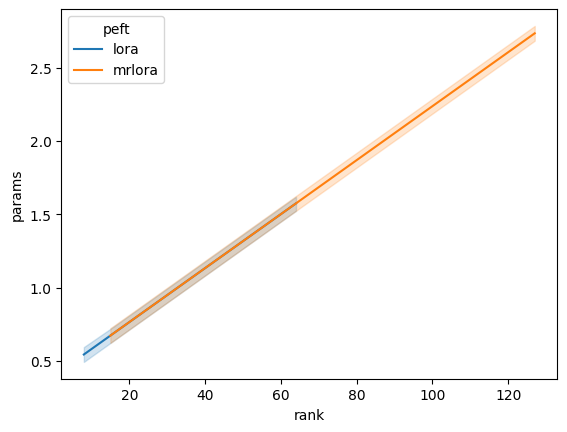

In [18]:
sns.lineplot(stu_mrlora, x='rank', y='params', hue='peft')

<Axes: xlabel='rank', ylabel='value'>

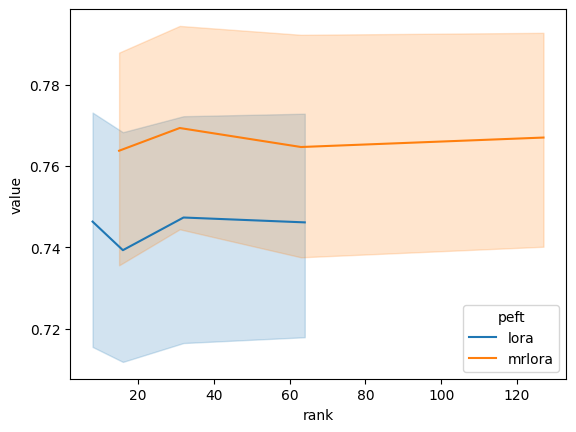

In [19]:
sns.lineplot(stu_mrlora, x='rank', y='value', hue='peft')
